<a href="https://colab.research.google.com/github/SamJSui/TVA_Movie/blob/main/TVA_Movie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Prologue

In [1]:
%%capture
!git clone https://github.com/SamJSui/TVA_Movie

In [2]:
!pip install -U matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Data
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Matrix
from scipy.sparse import csr_matrix 

# Model
from sklearn.neighbors import NearestNeighbors

In [4]:
df_movies = pd.read_csv("/content/TVA_Movie/movie.csv")
df_ratings = pd.read_csv("/content/TVA_Movie/rating.csv", low_memory=False)

## Movies

In [5]:
df_movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


In [6]:
df_movies.info

<bound method DataFrame.info of        movieId                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
27273   131254        Kein Bund für's Leben (2007)   
27274   131256       Feuer, Eis & Dosenbier (2002)   
27275   131258                  The Pirates (2014)   
27276   131260                 Rentun Ruusu (2001)   
27277   131262                    Innocence (2014)   

                                            genres  
0      Adventure|Animation|Children|Comedy|Fantasy  
1                       Adventure|Children|Fantasy  
2                                   Comedy|Romance  
3                             Comedy|Drama|Romance  
4                                           Comedy  
.

Checking for any NA values 

In [7]:
df_movies.isna().any()

movieId    False
title      False
genres     False
dtype: bool

In [8]:
df_movies['movieId'].unique().shape

(27278,)

The number of unique movie IDs matching the number of rows ➡ there are no duplicates when merging with the ratings

In [9]:
def genres_list(row):
  return str(row).split(sep='|')

df_movies['genres'] = df_movies['genres'].apply(genres_list)

Splitting the genres (previously separated by a pipe |) into list objects to make encoding easier 

In [10]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


## Ratings

In [11]:
df_ratings

,userId,movieId,rating,timestamp
0,1.0,2.0,3.5,4/2/2005 23:53
1,1.0,29.0,3.5,4/2/2005 23:31
2,1.0,32.0,3.5,4/2/2005 23:33
3,1.0,47.0,3.5,4/2/2005 23:32
4,1.0,50.0,3.5,4/2/2005 23:29
...,...,...,...,...
1048570,NaN,NaN,NaN,NaN
1048571,NaN,NaN,NaN,NaN
1048572,NaN,NaN,NaN,NaN
1048573,NaN,NaN,NaN,NaN


Timestamp appears to be the least relevant feature (will have to consider the changes of ratings over time for individually movies)

In [12]:
df_ratings.info

<bound method DataFrame.info of          userId  movieId  rating       timestamp
0           1.0      2.0     3.5  4/2/2005 23:53
1           1.0     29.0     3.5  4/2/2005 23:31
2           1.0     32.0     3.5  4/2/2005 23:33
3           1.0     47.0     3.5  4/2/2005 23:32
4           1.0     50.0     3.5  4/2/2005 23:29
...         ...      ...     ...             ...
1048570     NaN      NaN     NaN             NaN
1048571     NaN      NaN     NaN             NaN
1048572     NaN      NaN     NaN             NaN
1048573     NaN      NaN     NaN             NaN
1048574  7120.0    266.0     3.5  4/2/2007 19:34

[1048575 rows x 4 columns]>

In [13]:
df_ratings = df_ratings.dropna()

In [14]:
print(df_ratings.shape)
df_ratings.head()

(99999, 4)


,userId,movieId,rating,timestamp
0,1.0,2.0,3.5,4/2/2005 23:53
1,1.0,29.0,3.5,4/2/2005 23:31
2,1.0,32.0,3.5,4/2/2005 23:33
3,1.0,47.0,3.5,4/2/2005 23:32
4,1.0,50.0,3.5,4/2/2005 23:29


In [15]:
df_ratings.duplicated().any()

False

In [16]:
df_merged = df_movies.merge(df_ratings, on='movieId')

Merge the two dataframes to pair unique movie IDs to their designated reviews

# EDA

## Exploration

### Merged

In [17]:
df_merged

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.0,4.0,12/11/1999 13:36
1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",6.0,5.0,3/13/1997 17:50
2,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",8.0,4.0,6/5/1996 13:37
3,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",10.0,4.0,11/25/1999 2:44
4,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",11.0,4.5,1/2/2009 1:13
...,...,...,...,...,...,...
99994,119141,The Interview (2014),"[Action, Comedy]",631.0,3.0,3/21/2015 9:40
99995,125916,Fifty Shades of Grey (2015),[Drama],31.0,0.5,2/23/2015 23:20
99996,125916,Fifty Shades of Grey (2015),[Drama],692.0,0.5,2/18/2015 23:47
99997,128488,Wild Card (2015),"[Crime, Drama, Thriller]",284.0,3.0,2/25/2015 17:35


In [18]:
df_avg = df_merged.groupby('title').agg({'rating' : ['count', 'mean']})
df_avg.columns = ['count', 'mean']
df_avg = df_avg.sort_values(ascending=False, by=['count'])

df_avg

,count,mean
title,,
Pulp Fiction (1994),350,4.100000
Forrest Gump (1994),340,4.058824
"Shawshank Redemption, The (1994)",305,4.413115
Jurassic Park (1993),302,3.639073
"Silence of the Lambs, The (1991)",295,4.111864
...,...,...
Samurai I: Musashi Miyamoto (Miyamoto Musashi) (1954),1,4.000000
Samurai II: Duel at Ichijoji Temple (Zoku Miyamoto Musashi: Ichijôji no kettô) (1955),1,4.000000
Samurai III: Duel on Ganryu Island (a.k.a. Bushido) (Miyamoto Musashi kanketsuhen: kettô Ganryûjima) (1956),1,4.500000


### Genres

In [19]:
unique_genres = list(df_movies["genres"].explode().unique()) 

unique_genres

['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'IMAX',
 'Documentary',
 'War',
 'Musical',
 'Western',
 'Film-Noir',
 '(no genres listed)']

## Visualizations

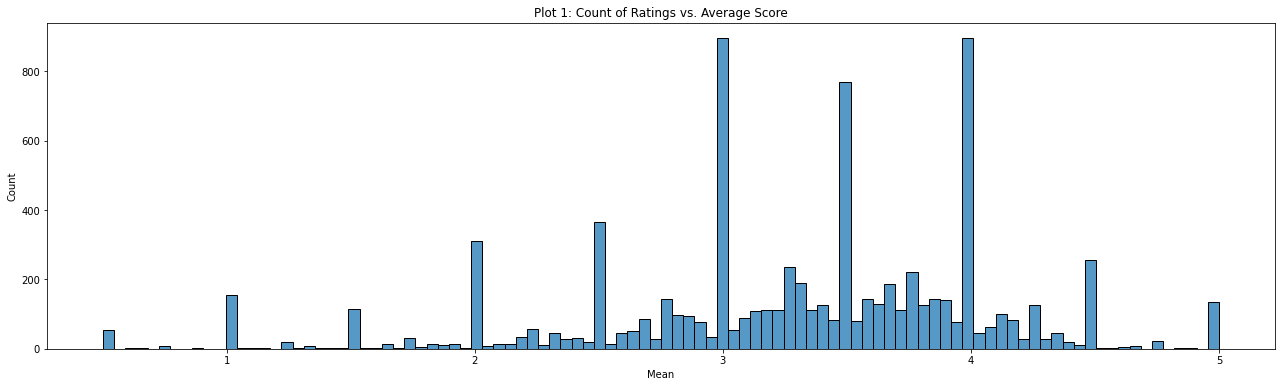

In [20]:
plt.figure(figsize=(22, 6))
mean_plot = sns.histplot(data=df_avg, x=df_avg['mean'], bins=100)
mean_plot.set(xlabel='Mean', ylabel='Count', title='Plot 1: Count of Ratings vs. Average Score')
fig = mean_plot.get_figure()
fig.savefig("mean_plot.png") 

Huge spikes occur at the whole numbers

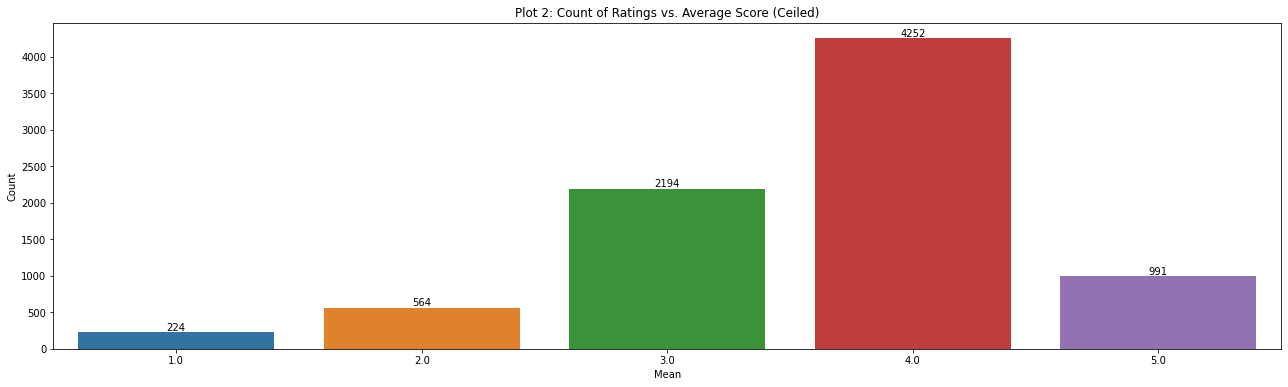

In [21]:
plt.figure(figsize=(22, 6))
mean_plot = sns.countplot(data=df_avg, x=df_avg['mean'].apply(np.ceil))
mean_plot.bar_label(mean_plot.containers[0])
mean_plot.set(xlabel='Mean', ylabel='Count', title='Plot 2: Count of Ratings vs. Average Score (Ceiled)')
fig = mean_plot.get_figure()
fig.savefig("mean_plot_ceiled.png") 
plt.show()

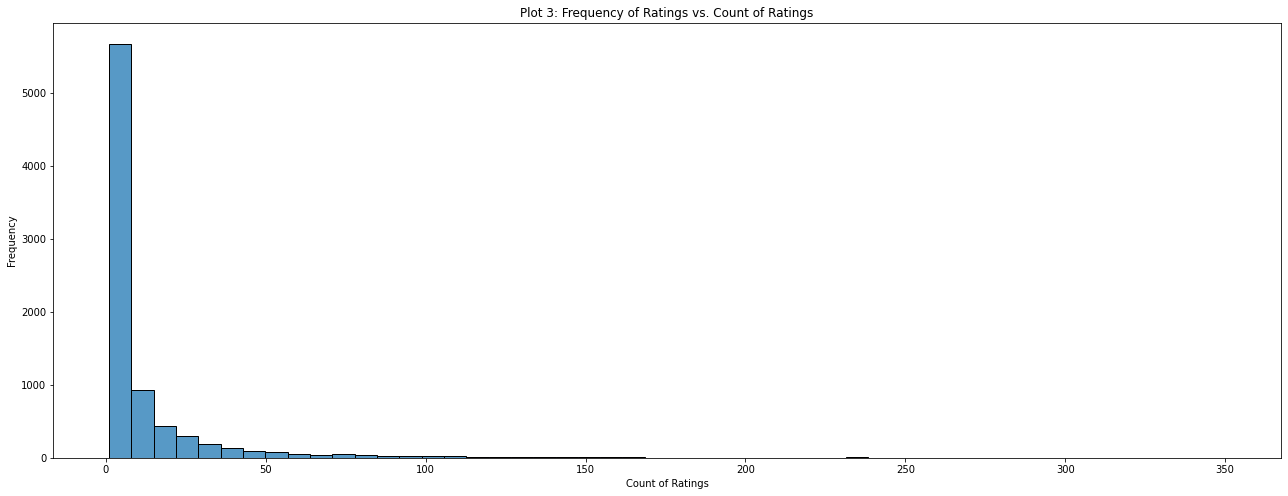

In [22]:
plt.figure(figsize=(22, 8))
count_plot = sns.histplot(data=df_avg, x='count', bins=50)
count_plot.set(xlabel='Count of Ratings', ylabel='Frequency', title='Plot 3: Frequency of Ratings vs. Count of Ratings')
fig = count_plot.get_figure()
fig.savefig("count_plot.png")
plt.show()

<Figure size 1512x576 with 0 Axes>

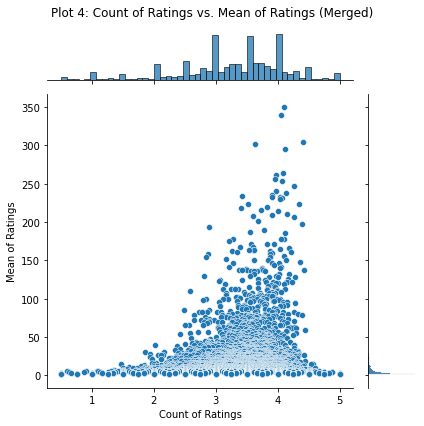

In [23]:
plt.figure(figsize=(21, 8))
merged_plot = sns.jointplot(data=df_avg, x='mean', y='count')
merged_plot.set_axis_labels('Count of Ratings', 'Mean of Ratings')
merged_plot.fig.suptitle('Plot 4: Count of Ratings vs. Mean of Ratings (Merged)')
plt.tight_layout()
fig = merged_plot.fig
fig.savefig("merged_plot.png")
plt.show()

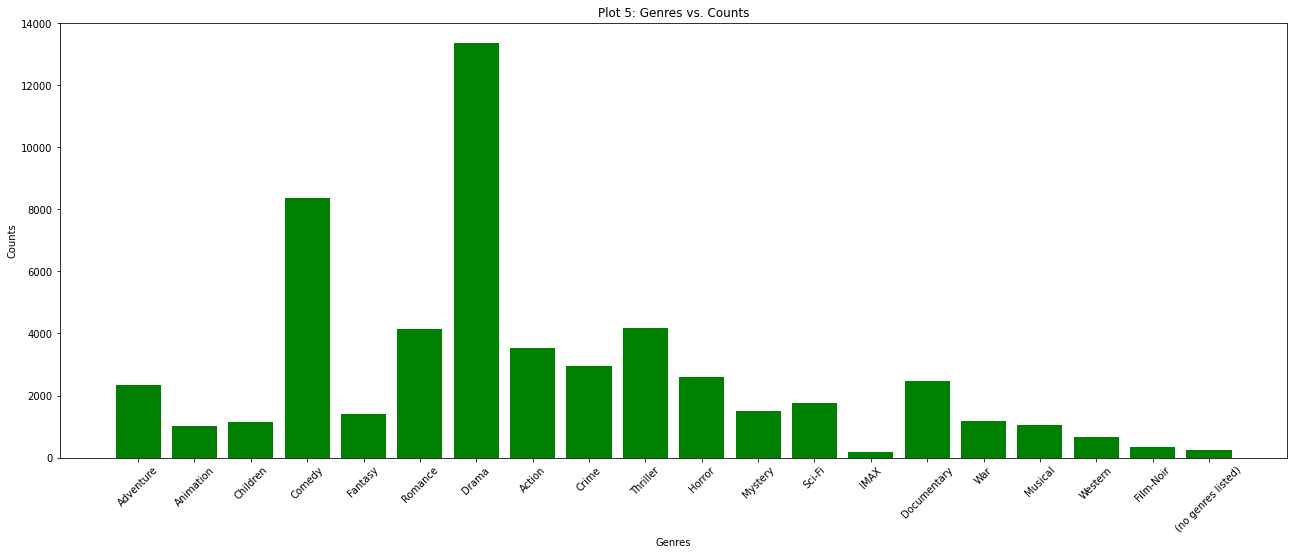

In [24]:
counts = dict()
for i in df_movies.index:
   for g in df_movies.loc[i, 'genres']:
      if g not in counts:
         counts[g] = 1
      else:
         counts[g] = counts[g] + 1

plt.figure(figsize=(22, 8))
plt.bar(list(counts.keys()), counts.values(), color='g')
plt.xticks(rotation=45)
plt.title('Plot 5: Genres vs. Counts')
plt.xlabel('Genres')
plt.ylabel('Counts')
plt.savefig('genre_plot.png')

**Insights**

- Plot 1 and 2 - Most of the movies are rated around 3-4, showing a slightly-left-skewed Gaussian distribution
- Plot 3 - Most of the movies have less than 50 ratings
- Plot 4 - The Jointplot confirms the idea that many of the reviews rate more movies around 3 or 4
- Plot 5 - Most movies are Dramas or Comedies

## Analysis and Cleaning

In [25]:
df_avg.describe()

,count,mean
count,8225.000000,8225.000000
mean,12.157933,3.281388
std,25.873208,0.815626
min,1.000000,0.500000
25%,1.000000,2.932432
50%,3.000000,3.416667
75%,10.000000,3.887097
max,350.000000,5.000000


In [26]:
df_clean = df_avg.loc[df_avg['count'] >= 12] 

Cleaning movies who have less than 12 reviews to mitigate large discrepancies in data, such as outliers

In [27]:
df_clean.describe()

,count,mean
count,1893.000000,1893.000000
mean,42.170629,3.466470
std,41.407976,0.480644
min,12.000000,1.464286
25%,17.000000,3.173077
50%,27.000000,3.521277
75%,49.000000,3.821429
max,350.000000,4.566667


In [28]:
df_merged = df_merged[df_merged['title'].isin(df_clean.index)]

In [29]:
df_movie_userid = df_merged.pivot_table(index="title", columns="userId", values='rating').fillna(0)

In [30]:
df_movie_userid.head()

userId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,694.0,695.0,696.0,697.0,698.0,699.0,700.0,701.0,702.0,7120.0
title,,,,,,,,,,,,,,,,,,,,,
"'burbs, The (1989)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0
(500) Days of Summer (2009),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Things I Hate About You (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
101 Dalmatians (1996),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101 Dalmatians (One Hundred and One Dalmatians) (1961),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


1893 Movies with 703 unique User IDs (that have more than 12 ratings)

# Modeling

## K-Nearest Neighbors

In [31]:
df_movie_matrix = csr_matrix(df_movie_userid.values)
df_movie_matrix

<1893x703 sparse matrix of type '<class 'numpy.float64'>'
	with 79826 stored elements in Compressed Sparse Row format>

Condense matrix into a sparse matrix to save memory

In [32]:
knn = NearestNeighbors(algorithm='brute', metric='cosine')
knn.fit(df_movie_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [36]:
movies = list(df_movie_userid.index)
query = "star wars" # TEST
query_list = [x for x in df_movie_userid.index if query.lower() in x.lower()]
print(query_list)

['Star Wars: Episode I - The Phantom Menace (1999)', 'Star Wars: Episode II - Attack of the Clones (2002)', 'Star Wars: Episode III - Revenge of the Sith (2005)', 'Star Wars: Episode IV - A New Hope (1977)', 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Star Wars: Episode VI - Return of the Jedi (1983)']


In [37]:
for query in query_list:
  query_idx = movies.index(query)
  distances, indices = knn.kneighbors(df_movie_userid.iloc[query_idx,:].values.reshape(1, -1), n_neighbors = 7)
  for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(df_movie_userid.index[query_idx]))
    else:
        print('{0}: {1}'.format(i, df_movie_userid.index[indices.flatten()[i]]))
  print('\n------\n')

Recommendations for Star Wars: Episode I - The Phantom Menace (1999):

1: Star Wars: Episode VI - Return of the Jedi (1983)
2: Star Wars: Episode V - The Empire Strikes Back (1980)
3: Matrix, The (1999)
4: Men in Black (a.k.a. MIB) (1997)
5: Star Wars: Episode IV - A New Hope (1977)
6: Fifth Element, The (1997)

------

Recommendations for Star Wars: Episode II - Attack of the Clones (2002):

1: Star Wars: Episode III - Revenge of the Sith (2005)
2: Matrix Reloaded, The (2003)
3: Star Wars: Episode I - The Phantom Menace (1999)
4: Matrix Revolutions, The (2003)
5: Spider-Man (2002)
6: Lord of the Rings: The Two Towers, The (2002)

------

Recommendations for Star Wars: Episode III - Revenge of the Sith (2005):

1: Star Wars: Episode II - Attack of the Clones (2002)
2: Batman Begins (2005)
3: Matrix Revolutions, The (2003)
4: King Kong (2005)
5: V for Vendetta (2006)
6: War of the Worlds (2005)

------

Recommendations for Star Wars: Episode IV - A New Hope (1977):

1: Star Wars: Episod

## Genre-Based Similarity (TO DO)

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

def combine_genres(row):
  return ' '.join(row)

df_merged['genres'] = df_merged['genres'].apply(combine_genres)

# create an object for TfidfVectorizer
tfidf_vector = TfidfVectorizer(stop_words='english')
# apply the object to the genres column
tfidf_matrix = tfidf_vector.fit_transform(df_merged['genres'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
